Generate test data for SASS implementation of the Gibson-Lanni PSF.

This Python algorithm has been verified against the original MATLAB code from the paper Li, J., Xue, F., & Blu, T. (2017). Fast and accurate three-dimensional point spread function computation for fluorescence microscopy. JOSA A, 34(6), 1029-1034.

In [1]:
import sys
%pylab inline
import scipy.special
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline

print('Python {}\n'.format(sys.version))
print('NumPy\t\t{}'.format(np.__version__))
print('matplotlib\t{}'.format(matplotlib.__version__))
print('SciPy\t\t{}'.format(scipy.__version__))

Populating the interactive namespace from numpy and matplotlib
Python 3.5.2 |Anaconda 2.5.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

NumPy		1.13.1
matplotlib	2.0.2
SciPy		0.19.1


# Simulation setup
## Define the simulation parameters

In [2]:
# Image properties
# Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 1

# Precision control
num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
num_samples  = 1000 # Number of pupil samples along radial direction
oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

# Microscope parameters
NA          = 1.4
wavelength  = 0.610 # microns
M           = 100   # magnification
ns          = 1.33  # specimen refractive index (RI)
ng0         = 1.5   # coverslip RI design value
ng          = 1.5   # coverslip RI experimental value
ni0         = 1.5   # immersion medium RI design value
ni          = 1.5   # immersion medium RI experimental value
ti0         = 150   # microns, working distance (immersion medium thickness) design value
tg0         = 170   # microns, coverslip thickness design value
tg          = 170   # microns, coverslip thickness experimental value
resPSF      = 0.02  # microns (resPSF in the Java code)
resLateral  = 0.1   # microns (resLateral in the Java code)
res_axial   = 0.25  # microns
pZ          = 2     # microns, particle distance from coverslip
z           = [-2]  # microns, stage displacement away from best focus

# Scaling factors for the Fourier-Bessel series expansion
min_wavelength = 0.436 # microns
scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength

## Create the coordinate systems

In [3]:
# Place the origin at the center of the final PSF array
x0 = (size_x - 1) / 2
y0 = (size_y - 1) / 2

# Find the maximum possible radius coordinate of the PSF array by finding the distance
# from the center of the array to a corner
max_radius = round(sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0))) + 1;

# Radial coordinates, image space
r = resPSF * np.arange(0, oversampling * max_radius) / oversampling

# Radial coordinates, pupil space
a = min([NA, ns, ni, ni0, ng, ng0]) / NA
rho = np.linspace(0, a, num_samples)

# Convert z to array
z = np.array(z)

# Step 1: Approximate the pupil phase with a Fourier-Bessel series

`z.reshape(-1,1)` flips `z` from a row array to a column array so that it may be broadcast across `rho`.

The coefficients `C` are found by a least-squares solution to the equation

\begin{equation*}
\mathbf{\phi} \left( \rho , z \right)= \mathbf{J} \left( \rho \right) \mathbf{c} \left( z \right)
\end{equation*}

\\( \mathbf{c} \\) has dimensions `num_basis` \\( \times \\) `len(z)`. The `J` array has dimensions `num_basis` \\( \times \\) `len(rho)` and the `phase` array has dimensions `len(z)` \\( \times \\) `len(rho)`. The `J` and `phase` arrays are therefore transposed to get the dimensions right in the call to `np.linalg.lstsq`.

In [4]:
# Define the wavefront aberration
OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)

# Sample the phase
# Shape is (number of z samples by number of rho samples)
phase = np.cos(W) + 1j * np.sin(W)

# Define the basis of Bessel functions
# Shape is (number of basis functions by number of rho samples)
J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)

# Compute the approximation to the sampled pupil phase by finding the least squares
# solution to the complex coefficients of the Fourier-Bessel expansion.
# Shape of C is (number of basis functions by number of z samples).
# Note the matrix transposes to get the dimensions correct.
C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)

# Step 2: Compute the PSF

Here, we use the Fourier-Bessel series expansion of the phase function and a Bessel integral identity to compute the approximate PSF. Each coefficient \\( c_{m} \left( z \right) \\) needs to be multiplied by

\begin{equation*}
R \left(r; \mathbf{p} \right) = \frac{\sigma_m J_1 \left( \sigma_m a \right) J_0 \left( \beta a \right)a - \beta J_0 \left( \sigma_m a \right) J_1 \left( \beta a \right)a }{\sigma_m^2 - \beta^2}
\end{equation*}

and the resulting products summed over the number of basis functions. \\( \mathbf{p} \\) is the parameter vector for the Gibson-Lanni model, \\( \sigma_m \\) is the scaling factor for the argument to the \\( m'th \\) Bessel basis function, and \\( \beta = kr\text{NA} \\).

`b` is defined such that `R` has dimensions of `len(r)` \\( \times \\) `len(rho)`.

In [5]:
b = 2 * np. pi * r.reshape(-1, 1) * NA / wavelength

# Convenience functions for J0 and J1 Bessel functions
J0 = lambda x: scipy.special.jv(0, x)
J1 = lambda x: scipy.special.jv(1, x)

# See equation 5 in Li, Xue, and Blu
denom = scaling_factor * scaling_factor - b * b
R = (scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a)
R /= denom

Now compute the point-spread function via

\begin{equation*}
PSF \left( r, z; z_p, \mathbf{p} \right) = \left| \mathbf{R} \left( r; \mathbf{p} \right) \mathbf{c} \left( z \right) \right|^2
\end{equation*}

In [6]:
# The transpose places the axial direction along the first dimension of the array, i.e. rows
# This is only for convenience.
PSF_rz = (np.abs(R.dot(C))**2).T

# Step 3: Resample the PSF onto a rotationally-symmetric Cartesian grid

Here we generate a two dimensional grid where the value at each grid point is the distance of the point from the center of the grid. These values are supplied to an interpolation function computed from `PSF_rz` to produce a rotationally-symmetric 2D PSF at each z-position.

In [7]:
# Create the fleshed-out xy grid of radial distances from the center
xy      = np.mgrid[0:size_y, 0:size_x]
r_pixel = np.sqrt((xy[1] - x0) * (xy[1] - x0) + (xy[0] - y0) * (xy[0] - y0)) * resPSF

PSF = np.zeros((size_y, size_x, size_z))

for z_index in range(PSF.shape[2]):
    # Interpolate the radial PSF function
    PSF_interp = interp1d(r, PSF_rz[z_index, :])
    
    # Evaluate the PSF at each value of r_pixel
    PSF[:,:, z_index] = PSF_interp(r_pixel.ravel()).reshape(size_y, size_x)

In [8]:
# Normalize to the area
norm_const = np.sum(np.sum(PSF[:,:,0])) * resPSF**2
PSF /= norm_const

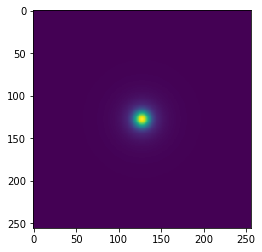

In [9]:
plt.imshow(PSF[:,:,0])
plt.show()

# Compute the cumulative distribution

In [10]:
cdf = np.cumsum(PSF[:,:,0], axis=1) * resPSF
cdf = np.cumsum(cdf, axis=0) * resPSF
print('Min: {:.4f}'.format(np.min(cdf)))
print('Max: {:.4f}'.format(np.max(cdf)))

Min: 0.0000
Max: 1.0000


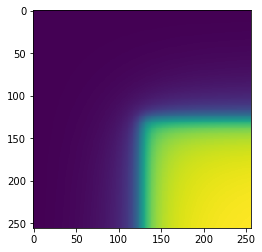

In [11]:
plt.imshow(cdf)
plt.show()

## Interpolate the cumulative distribution

Here, we also create the Python equivalent to the getPixelSignature function.

Note that the ground truth is not symmetric about the center pixel because of the finite sampling of the CDF; it becomes more symmetric the smaller resPSF is and the larger sizeX/Y are.

In [12]:
x = (resPSF * (xy[1] - x0))[0]
y = (resPSF * (xy[0] - y0))[:,0]

# Compute the interpolated CDF
f = RectBivariateSpline(x, y, cdf)

In [13]:
def generatePixelSignature(pX, pY, eX, eY, eZ):
    value = f((pX - eX + 0.5) * resLateral, (pY - eY + 0.5) * resLateral) + \
            f((pX - eX - 0.5) * resLateral, (pY - eY - 0.5) * resLateral) - \
            f((pX - eX + 0.5) * resLateral, (pY - eY - 0.5) * resLateral) - \
            f((pX - eX - 0.5) * resLateral, (pY - eY + 0.5) * resLateral)
    return value

In [14]:
generatePixelSignature(0, 0, 0, -1, 0)

array([[ 0.02800397]])

In [15]:
generatePixelSignature(1, 1, 1, 1, 0)

array([[ 0.03726069]])

In [16]:
generatePixelSignature(2, 1, 1, 1, 0)

array([[ 0.02800397]])

In [17]:
generatePixelSignature(0, 1, 1, 1, 0)

array([[ 0.03077785]])

In [18]:
generatePixelSignature(1, 2, 1, 1, 0)

array([[ 0.02800397]])

In [19]:
generatePixelSignature(1, 0, 1, 1, 0)

array([[ 0.03077785]])

In [20]:
generatePixelSignature(-1, 1, 1, 1, 0)

array([[ 0.01628886]])

In [21]:
generatePixelSignature(3, 1, 1, 1, 0)

array([[ 0.01377306]])